# Updates

After updating packages, restart the session and then start your notebook from imports.

# Imports

In [107]:
# import torch
# from transformers import AutoTokenizer, AutoModelForCausalLM
import json
import pandas as pd
import re
import string
import spacy
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

## Reading Json Files

In [77]:
def jsonl_tolist(jsonl_file_path):
    records = []
    with open(jsonl_file_path, 'r') as f:
        for line in f:
            record = json.loads(line)
            records.append(record)
    return records


In [78]:
jsonl_files_path = {
    "train": "imdb/train_imdb.jsonl",
    "test": "imdb/test_imdb.jsonl",
    "unlabeled": "imdb/aug_imdb_unlabeled.jsonl"
}

In [79]:
df_train = pd.DataFrame(jsonl_tolist(jsonl_files_path["train"]))
df_test = pd.DataFrame(jsonl_tolist(jsonl_files_path["test"]))
df_unlabeled = pd.DataFrame(jsonl_tolist(jsonl_files_path["unlabeled"]))

In [80]:
df_train.to_csv("CSVs/train.csv")
df_test.to_csv("CSVs/test.csv")
df_unlabeled.to_csv("CSVs/unlabeled.csv")

In [81]:
def get_feature_columns_name(df):
    features_columns = []
    for i in range(len(df["embedding"][0])):
        name = "feature" + f"{i + 1}"
        features_columns.append(name)
    return features_columns

In [82]:
df_train[get_feature_columns_name(df_train)] = df_train["embedding"].apply(pd.Series)
df_test[get_feature_columns_name(df_test)] = df_test["embedding"].apply(pd.Series)
df_unlabeled[get_feature_columns_name(df_unlabeled)] = df_unlabeled["embedding"].apply(pd.Series)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13456\1150993862.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[get_feature_columns_name(df_train)] = df_train["embedding"].apply(pd.Series)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13456\1150993862.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[get_feature_columns_name(df_train)] = df_train["embedding"].apply(pd.Series)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_13456\1150993862.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usual

In [83]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)


In [84]:
def to_lowercase(text):
    return text.lower()

In [85]:
def remove_digits(text):
    return re.sub("\w*\d\w*", "", text)

In [86]:
def remove_punctuation(text):
    return re.sub("[%s]" % re.escape(string.punctuation), "", text)

In [87]:
def remove_short_words(text):
        return " ".join(word for word in text.split() if len(word) >= 3 or word.lower() == "no")

In [88]:
def remove_extra_spaces(text):
    return re.sub(" +", " ", text)

In [89]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

negation_words = {"not", "no", "never", "none", "nobody", "nothing", "neither", "nowhere", "cannot"}

def lemmatize_and_remove_stop_words(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop or token.text.lower() in negation_words])

In [90]:
def calculate_polarity(text):
    return TextBlob(text).sentiment.polarity

In [91]:
def preprocess_dataframe(df):
    df = df.copy()
    df["text"] = df["text"].apply(expand_contractions)
    df["text"] = df["text"].apply(to_lowercase)
    df["text"] = df["text"].apply(remove_digits)
    df["text"] = df["text"].apply(remove_punctuation)
    df["text"] = df["text"].apply(remove_short_words)
    df["text"] = df["text"].apply(remove_extra_spaces)
    df["text"] = df["text"].apply(lemmatize_and_remove_stop_words)
    df["polarity"] = df["text"].apply(calculate_polarity)
    return df

In [92]:
df_train = preprocess_dataframe(df_train)
df_test = preprocess_dataframe(df_test)
df_unlabeled = preprocess_dataframe(df_unlabeled)

## Understanding the common words used in the texts

In [117]:
from sklearn.feature_extraction.text import CountVectorizer


def plot_common_ngrams(all_text, n=2, bg_color="white"):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngram_matrix = vectorizer.fit_transform([all_text])
    ngram_names = vectorizer.get_feature_names_out()
    ngram_counts = ngram_matrix.sum(axis=0)
    ngram_dict = {ngram: count for ngram, count in zip(ngram_names, ngram_counts.tolist()[0])}
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,background_color=bg_color).generate_from_frequencies(ngram_dict)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Common {n}-grams")
    plt.show()

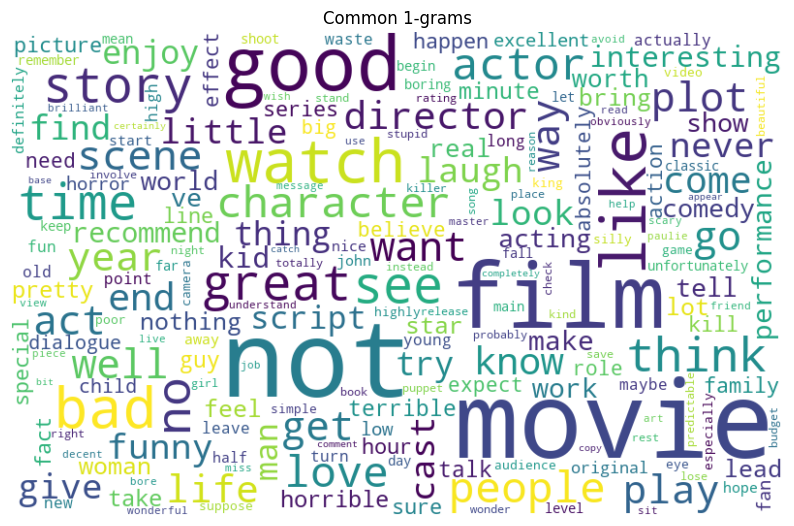

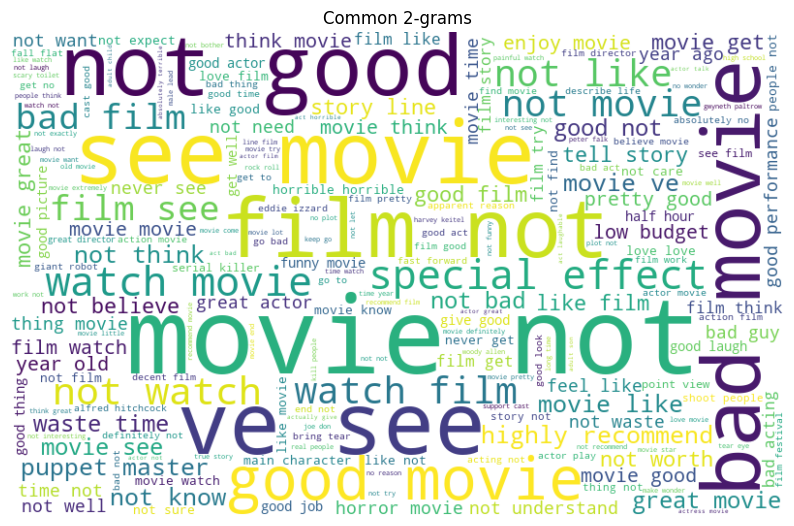

In [123]:
combi = pd.concat([df_train, df_test], ignore_index=True)
all_words = " ".join([text for text in combi["text"]])
plot_common_ngrams(all_words, n=1)
plot_common_ngrams(all_words, n=2)

### Words in positive texts

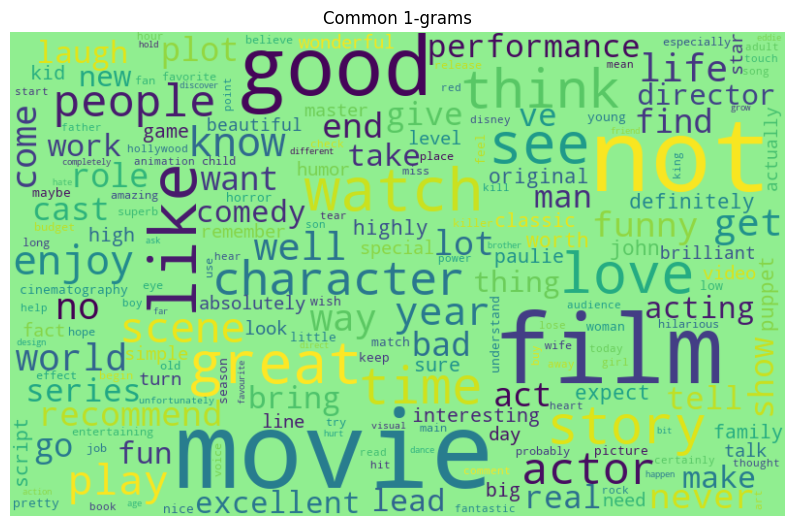

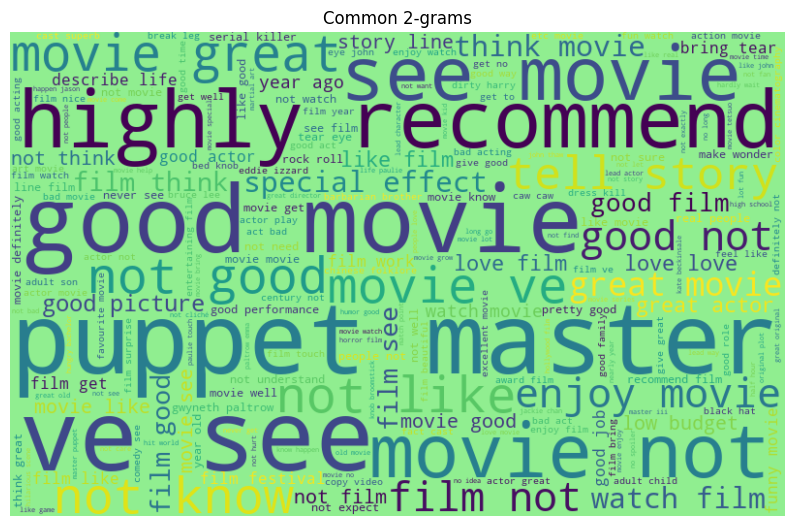

In [124]:
positive_words = " ".join([text for text in combi["text"][combi["label"] == 1]])
plot_common_ngrams(positive_words, n=1, bg_color="#90EE90")
plot_common_ngrams(positive_words, n=2, bg_color="#90EE90")

### Words in negative texts

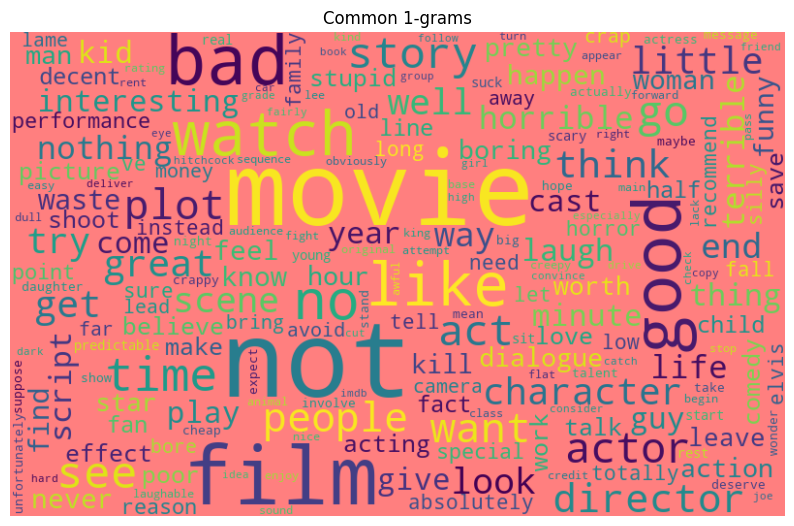

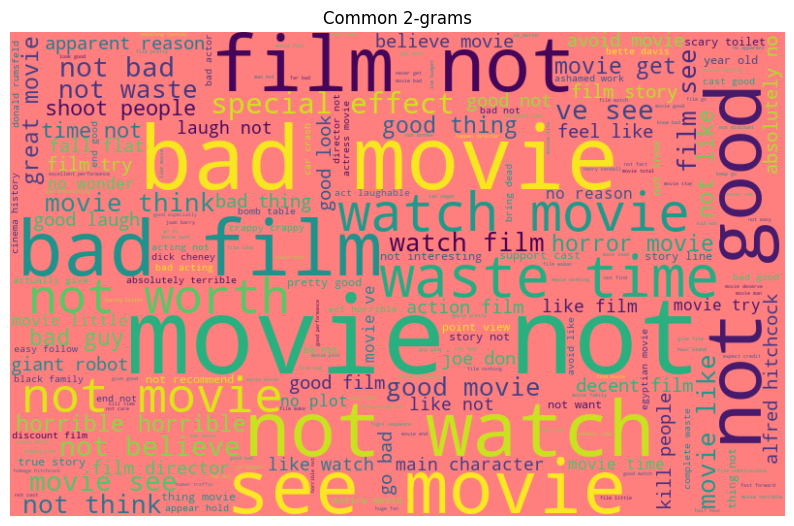

In [125]:
negation_words = " ".join([text for text in combi["text"][combi["label"] == 0]])
plot_common_ngrams(negation_words, n=1, bg_color="#FF7F7F")
plot_common_ngrams(negation_words, n=2, bg_color="#FF7F7F")

## Sentence Lenght analysis

In [112]:
df_train["text_word_count"] = df_train["text"].apply(lambda x: len(str(x).split()))
df_test["text_word_count"] = df_test["text"].apply(lambda x: len(str(x).split()))

In [110]:
def plot_text_length_distribution(df):
    positive_df = df[df["label"] == 1]
    negative_df = df[df["label"] == 0]

    plt.figure(figsize=(10, 6))
    sns.histplot(data=positive_df, x="text_word_count", bins=50, kde=False, color="green", label="Positive")
    sns.histplot(data=negative_df, x="text_word_count", bins=50, kde=False, color="red", label="Negative")
    plt.xlabel("Text Length")
    plt.ylabel("Count")
    plt.title("Text Length Distribution (Positive vs. Negative)")
    plt.legend()
    plt.show()


### For train dataset

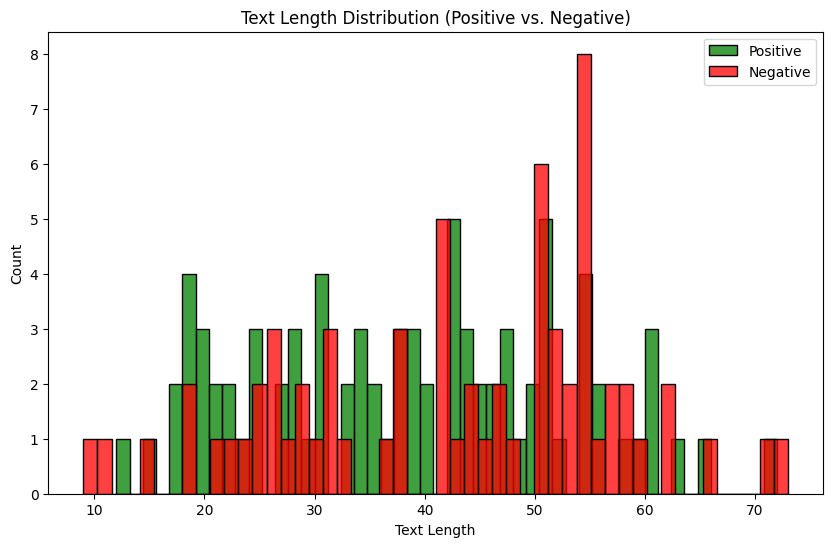

In [108]:
plot_text_length_distribution(df_train)


### For Test dataset

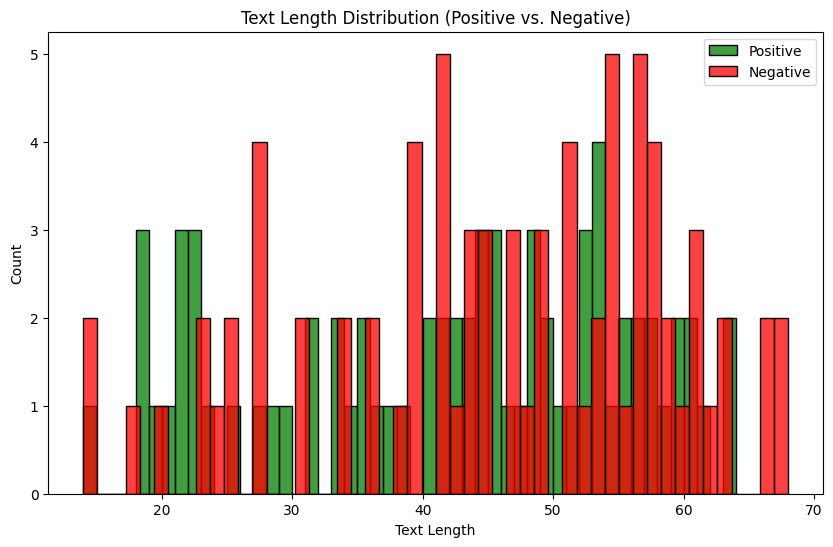

In [113]:
plot_text_length_distribution(df_test)

# Load model

In [ ]:
MODEL_ARGS = {
    'Name': 'microsoft/Phi-3-mini-128k-instruct',
    'DType': bfloat16
}

In [ ]:
def load_model(model_args):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype=torch.model_args['DType'],
        low_cpu_mem_usage=True,
        device_map={"": device},
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )

    return model, tokenizer

Good luck :)